In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import torch
from pyroomacoustics.doa import circ_dist
from scipy.io import wavfile
from IPython.display import Audio

In [2]:
# Get google speech command data
pra.datasets.google_speech_commands.GoogleSpeechCommands(download=True)

Dataset exists! Using ./google_speech_commands


/home/jd/anaconda3/envs/sit_int/lib/python3.10/site-packages/pyroomacoustics/datasets/google_speech_commands.py:198: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(path)


# Motivation 
We are developing a framework to enable _situated interaction_ for a human-robot team. We want the robot to select its course of action based on the current context, including inputs and sensory data from teammates and other people in the scene.

Since audio contains a wealth of contextual information about the scene and agents in it, we want to examine if we can __reliably__ use a multichannel audio array to extract the audio signal at a given location. The audio signal can then be parsed for speech, emotion, or voice identification and attributed to an agent to enable more rich situated interaction.

# Design the array/Hardware selection
A commercially-available multichannel audio array can enable audio signal acquisition on a mobile robot. We have a 16-channel audio array with sampling frequency $f_s = 44100 Hz$. Each microphone can be independently mounted on a medium-sized mobile robot with length and width on the order of __.5 meter__.

Hence, for this analysis we use a 4-channel planar, square array where each side has length = .5m.

In [24]:
# Microphone array parameters
f_s_array = 16000
n_fft = 1024
Lg_t = .1 # length of time domain filter in seconds
Lg = np.ceil(Lg_t*f_s_array)       # length of time domain filter in samples
square_array_R = np.array([[0.25, 0.25, -0.25, -0.25], # x
                [-.25, 0.25, -.25, 0.25]]) # y

# Sound source location and signal
fs, audio = wavfile.read('./google_speech_commands/go/004ae714_nohash_0.wav')
source_loc = [5.,0.]

# "Room" / Audio environment parameters
room_side_length = 20
corners = np.array([[room_side_length/2,room_side_length/2],[room_side_length/2,-room_side_length/2],[-room_side_length/2,-room_side_length/2],[-room_side_length/2,room_side_length/2]]).T
room = pra.Room.from_corners(corners, fs=fs)

# Create beamformer
bf = pra.Beamformer(square_array_R,f_s_array,N=n_fft, Lg=Lg)

# Add source and array to room
room.add_microphone_array(bf)
room.add_source(source_loc,signal=audio)
room.simulate()

# Compute beamformer weights
bf.far_field_weights(0)

# Plot Beam Response at different frequencies, incident azimuths

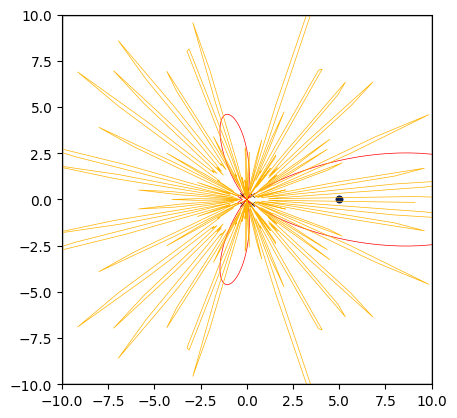

In [25]:
## Beam plot
# Visualize
fig,ax = room.plot(freq=[500, 8000])

Speech is a broadband signal, with low frequency of ~500 Hz and high frequency of ~8000 Hz.

For this array geometry, __low frequency have a few broad sidelobes__ and __high frequency have several smaller sidelobes__.

In other words, even if the beam is steered at the source, interfering signals from the sidelobes may be extracted instead.

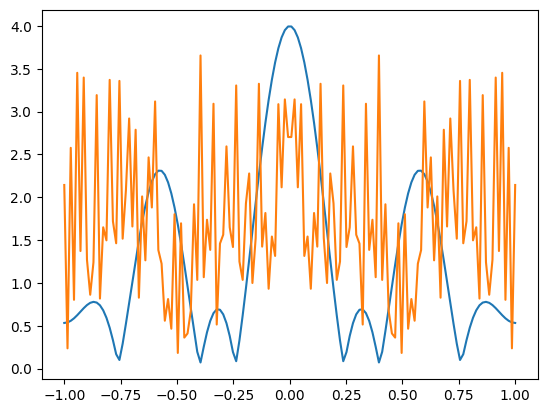

In [26]:
## Azimuth gain plot by frequencies
az_list = np.linspace(-180, 180, 140)*np.pi/180
# print(az_list)
az_list_pi = az_list/np.pi
# print(az_list_pi)

low_freq_resp = bf.response(az_list,500)
high_freq_resp = bf.response(az_list,8000)

plt.plot(az_list_pi,np.linalg.norm(np.array([[low_freq_resp[1]]]),axis=1).T)
plt.plot(az_list_pi,np.linalg.norm(np.array([[high_freq_resp[1]]]),axis=1).T)

On a polar plot, we can also see the low (blue) and high frequency gain (orange) of the beamformer.

# Spectral analysis

In [44]:
# Sanity check - listen to audio
fs, audio = wavfile.read('./google_speech_commands/go/004ae714_nohash_0.wav')
print(audio.shape)
Audio(data=audio,rate=fs)


(11146,)


In [59]:
dist = 1
phi = 0*np.pi/180
bf.rake_delay_and_sum_weights(pra.soundsource.SoundSource([dist*np.cos(phi),dist*np.sin(phi)]))
room.simulate()
audio_0=bf.process()
print(audio_0.shape)
Audio(data=audio_0,rate=fs)

(14003,)


In [53]:
bf.far_field_weights(45)
room.simulate()
audio_45=bf.process()
print(audio_45.shape)
Audio(data=audio_45,rate=fs)

(14003,)


In [55]:
all(audio_0 == audio_45)

True

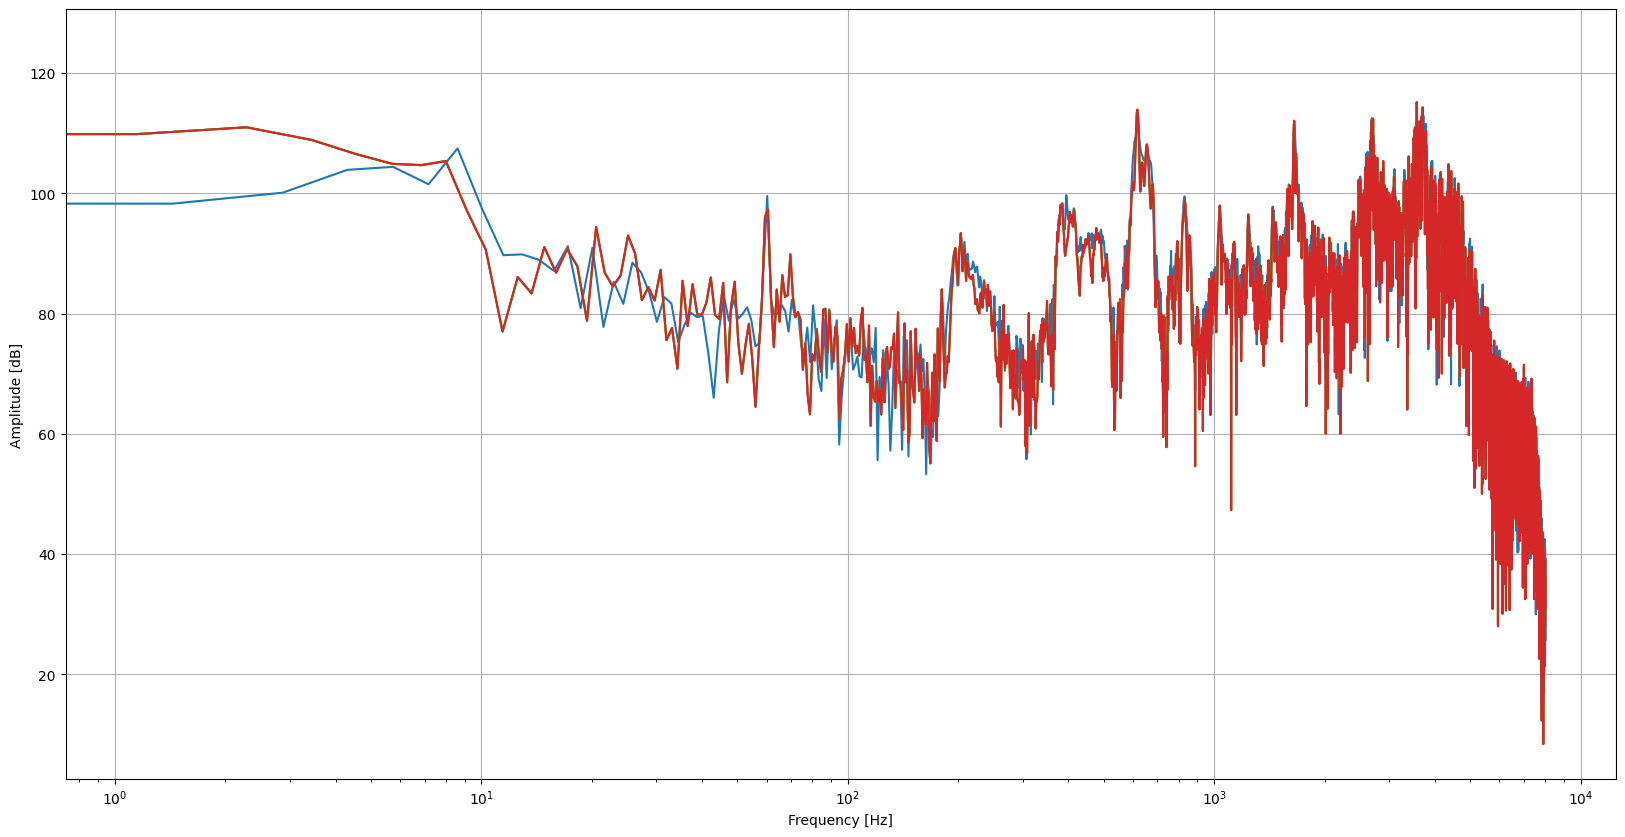

In [65]:
def plot_spec(spec, t_audio, frame_len, fs, hop=None):
    
    if hop is None:
        hop = frame_len
        
    fig, ax = plt.subplots(figsize=(20,7))
    spec = np.swapaxes(spec, 0 ,1)
    cax = ax.imshow(spec, interpolation=None, origin='lower', aspect='auto')
    ax.set_xlabel("Time [seconds]", fontsize=30)
    ax.set_ylabel("Frequency [Hz]", fontsize=30)
    x_labels = np.arange(max(t_audio), step=0.5)
    plt.xticks(x_labels*fs//hop, x_labels, fontsize=20)
    freqs = np.arange(frame_len//2+1) / frame_len * fs
    y_labels = np.arange(max(freqs)+1, step=1000).astype(int)
    plt.yticks(y_labels//(fs/frame_len), y_labels, fontsize=20)
    plt.tight_layout()

# load WAV file and take real FFT
fs, audio = wavfile.read('./google_speech_commands/go/004ae714_nohash_0.wav')
X = np.fft.rfft(audio)
freqs = np.arange(len(X)) / len(audio) * fs

## Spectrogram - beam aimed at it, 1 m
dist = 1
phi = 0*np.pi/180
bf.rake_delay_and_sum_weights(pra.soundsource.SoundSource([dist*np.cos(phi),dist*np.sin(phi)]))
room.simulate()
bf.process()
X_bf_1_0 = np.fft.rfft(bf.process())
bf_1_0_freqs = np.arange(len(X_bf_1_0)) / len(bf.process()) * fs

## Spectrogram - beam aimed at it, 5 m
dist = 5
phi = 0*np.pi/180
bf.rake_delay_and_sum_weights(pra.soundsource.SoundSource([dist*np.cos(phi),dist*np.sin(phi)]))
room.simulate()
bf.process()
X_bf_5_0 = np.fft.rfft(bf.process())
bf_5_0_freqs = np.arange(len(X_bf_5_0)) / len(bf.process()) * fs

## Spectrogram - beam aimed at it, 5 m
dist = 5
phi = 90*np.pi/180
bf.rake_delay_and_sum_weights(pra.soundsource.SoundSource([dist*np.cos(phi),dist*np.sin(phi)]))
room.simulate()
bf.process()
X_bf_5_90 = np.fft.rfft(bf.process())
bf_5_90_freqs = np.arange(len(X_bf_5_90)) / len(bf.process()) * fs



# visualize spectrum
plt.figure(figsize=(20,10))
# plt.semilogx(freqs, pra.dB(X), bf_freqs, pra.dB(X_bf), bf_45_freqs, pra.dB(X_bf_45), bf_90_freqs, pra.dB(X_bf_90), bf_135_freqs, pra.dB(X_bf_135), bf_180_freqs, pra.dB(X_bf_180))
plt.semilogx(freqs, pra.dB(X), bf_1_0_freqs, pra.dB(X_bf_1_0), bf_5_0_freqs, pra.dB(X_bf_5_0), bf_5_90_freqs, pra.dB(X_bf_5_90))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.grid()


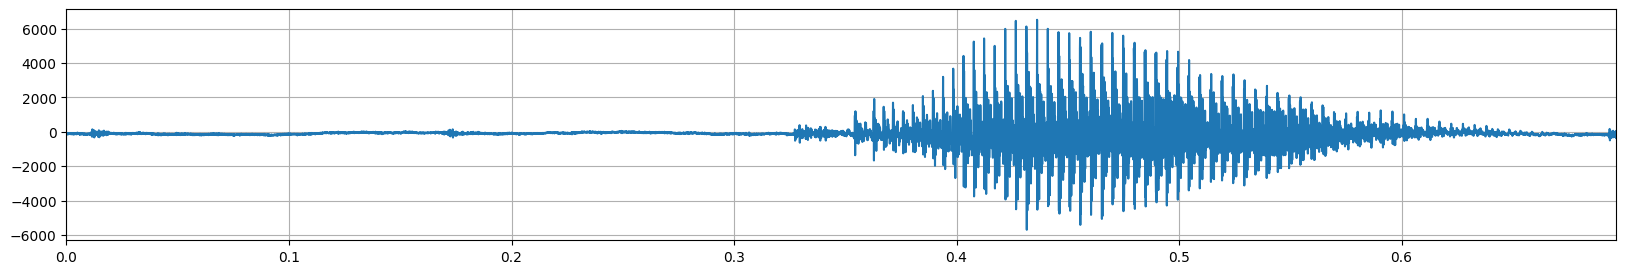

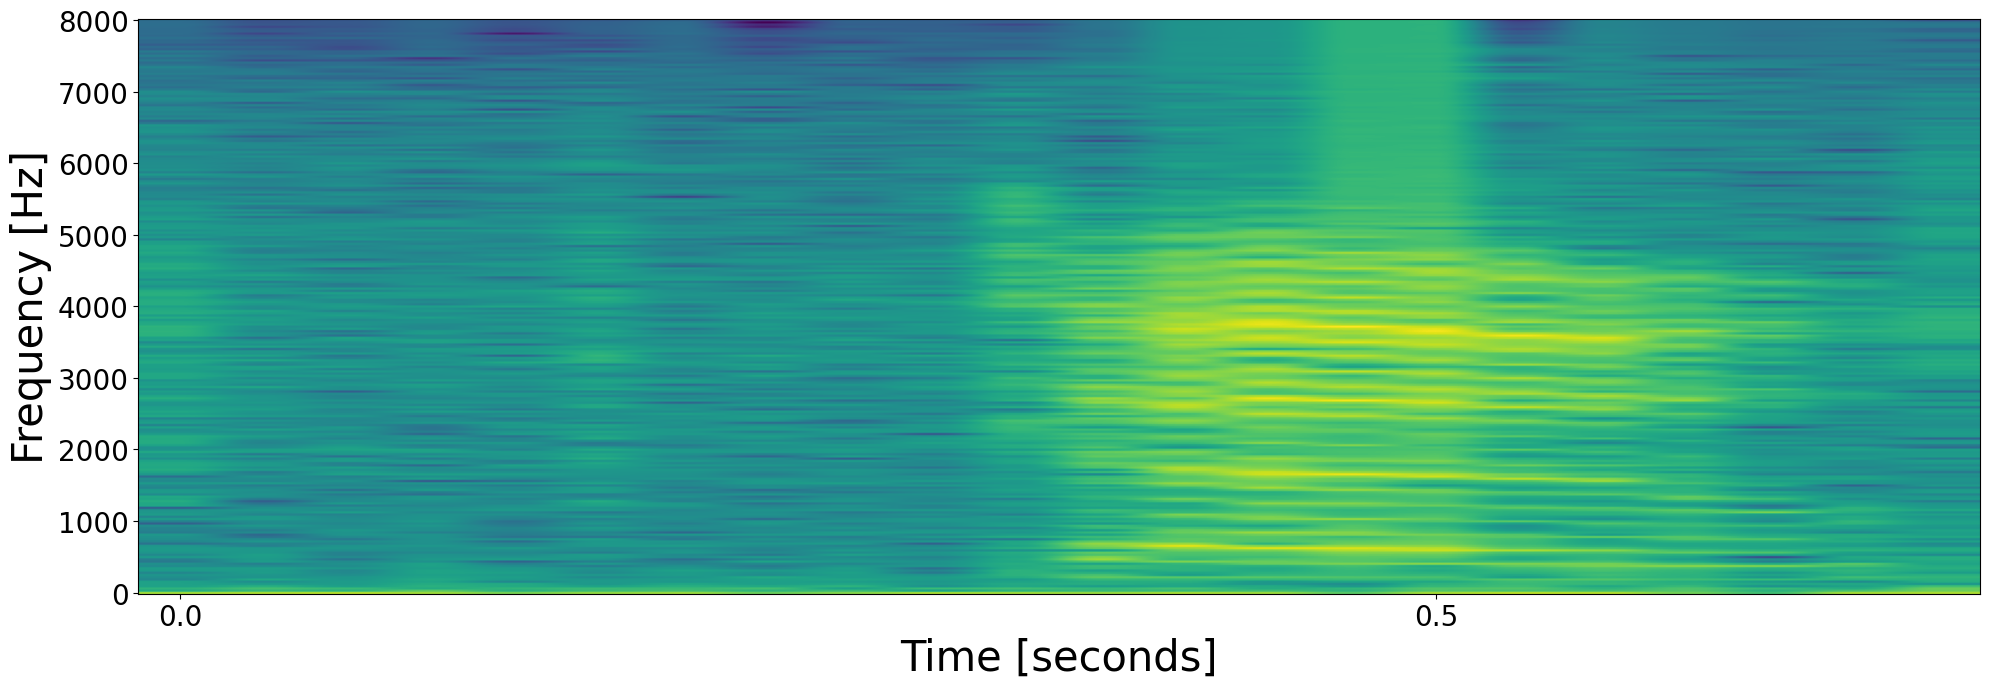

In [28]:
## Spectrum/FFT in
frame_len = 512

stft_obj = pra.transform.stft.STFT(N=frame_len, hop=frame_len)
X = stft_obj.analysis(audio)
spec = pra.dB(X)  
    
# visualize
t_audio = np.arange(len(audio))/fs
plt.figure(figsize=(20,3))
plt.plot(t_audio, audio)
plt.xlim(0, max(t_audio))
plt.grid()

plot_spec(spec, t_audio, frame_len, fs)


## Spectrum/FFT in
## Spectrum/FFT - beam aimed at it
## Spectrum/FFT - beam aimed away

# Command recognition